In [1]:
% load_ext autoreload
% autoreload 2

import numpy as np
import time
import datetime
import os 
import matplotlib.pyplot as plt
import matplotlib.style as stl
import matplotlib.gridspec as gridspec
import pickle
import pandas as pd
import seaborn as sns
from scipy import stats
import behav_annotation
from behav_annotation import Behav
from BehavPreprocess_j import BehavPreprocess
from DimReduction import DimReduction
from Segmentation import Segmentation
from GetResults import GetResults
from plot_results_util import *

def fix_layout(width:int=90): 
    from IPython.core.display import display, HTML 
    display(HTML("<style>.container { width:" + str(width) + "% !important; }</style>")) 

fix_layout()
start_time = time.time()

# Reading Data, excluding Rest frames

In [2]:
train_dir = behav_annotation.all_dir #adn_save  #[0:11:3]
fly_tags = behav_annotation.fly_tags #adn_pr_tags #[0:11:3] #IMPORTANT - if >1 pose files in folder, check order below first
val_dir = behav_annotation.train_dir_single #adn_val #val_dir

print("Preprocessing training dataset...")
train_dataset = BehavPreprocess(root_dir=train_dir, min_frequency=3, num_channels=20,
                                use_angles=True, normalize=True, halla_method=True)
print("Preprocessing validation dataset...")
val_dataset = BehavPreprocess(root_dir=val_dir, min_frequency=3, num_channels=20,
                              use_angles=True, normalize=True, halla_method=True)

train_data = train_dataset.data_concat
val_data = val_dataset.data_concat
train_behav = train_dataset.data_behav_concat
val_behav = val_dataset.data_behav_concat

# Low energy & boundary frame removal: if mask is turned off, preprocessing will keep all the frames
train_mask = train_behav != Behav.BOUNDARY.value # or Behav.REST.value
val_mask = val_behav != Behav.BOUNDARY.value # or Behav.REST.value
mask_off = False
if mask_off:
    train_mask = np.logical_not(np.logical_xor(train_mask, train_mask)) #turns mask into all True
    val_mask = np.logical_not(np.logical_xor(val_mask, val_mask))
    
# # Random train mask for sampling [testing]
# train_mask = np.random.choice([0, 1], size=(len(train_data),), p=[1./20, 19./20])==1;

train_data = train_data[train_mask, :]; print(f'train data shape: {np.shape(train_data)}')
val_data = val_data[val_mask, :]; print(f'val data shape: {np.shape(val_data)}')

train_frame_index = train_dataset.frame_idx[train_mask] #array of frames that are not rest frames
train_exp_index = train_dataset.exp_idx[train_mask] #array of experiment labels

train_data[np.logical_or(np.isnan(train_data), np.isinf(train_data))] = 0
val_data[np.logical_or(np.isnan(val_data), np.isinf(val_data))] = 0

train_activity = np.concatenate(train_dataset.frame_activity_list, axis=0)[train_mask]
val_activity = np.concatenate(val_dataset.frame_activity_list, axis=0)[val_mask]

parameters_dict = {}
results_dict = {}
parameters_dict['Preprocess'] = train_dataset.results_dict # TODO (dictionaries aren't prioritary)
results_dict['Preprocess'] = train_dataset.parameters_dict # TODO

Preprocessing training dataset...
Training directories: ['/Volumes/jhc_data/JHC/paper/180920_aDN_PR/Fly2/001_SG1/behData/images/pose_result__data_paper_180920_aDN_PR_Fly2_001_SG1_behData_images.pkl', '/Volumes/jhc_data/JHC/paper/180920_aDN_PR/Fly2/002_SG1/behData/images/pose_result__data_paper_180920_aDN_PR_Fly2_002_SG1_behData_images.pkl', '/Volumes/jhc_data/JHC/paper/180920_aDN_PR/Fly2/003_SG1/behData/images/pose_result__data_paper_180920_aDN_PR_Fly2_003_SG1_behData_images.pkl', '/Volumes/jhc_data/JHC/paper/180920_aDN_PR/Fly2/004_SG1/behData/images/pose_result__data_paper_180920_aDN_PR_Fly2_004_SG1_behData_images.pkl', '/Volumes/jhc_data/JHC/paper/180920_aDN_PR/Fly2/005_SG1/behData/images/pose_result__data_paper_180920_aDN_PR_Fly2_005_SG1_behData_images.pkl', '/Volumes/jhc_data/JHC/paper/180920_MDN_PR/Fly9/001_SG1/behData/images/pose_result__data_paper_180920_MDN_PR_Fly9_001_SG1_behData_images.pkl', '/Volumes/jhc_data/JHC/paper/180920_MDN_PR/Fly9/002_SG1/behData/images/pose_result__d

/Users/joaohenrique/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/joaohenrique/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/joaohenrique/Documents/EPFL/joao_pose/joint_functions.py:826: RuntimeWarning: invalid value encountered in greater
  too_far_away = abs(datamat_j[:, joint] - mean_before_first) > ld_correction*2 # Find the points that are too far away from that point


Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.06617656260850602
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.06864975522549477
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.03885735824727776
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.026078452550907905
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE -0.0239036919452702
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.3090018739192417
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.4699502149508139
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.27298254720367376
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.14839855359211418
Calculating joint angles...
Number of nan or inf after angles: 0
C

# Dimensionality Reduction

In [24]:
low_dim = DimReduction(train_data.copy(), val_data.copy(), single=True, use_tsne=True, validation=False,
                       pca_dim=50, tsne_per=np.sqrt(np.shape(train_data)[0])) # if use_tsne=False, uses PCA only
low_dim_train = low_dim.low_dim_train
# low_dim_val = low_dim.low_dim_val
parameters_dict['DimReduct'] = low_dim.results_dict
results_dict['DimReduct'] = low_dim.parameters_dict

Applying t-SNE with parameters {'perplexity': 149.57941034781493, 'early_exaggeration': 20.0, 'learning_rate': 100, 'n_iter': 2500, 'n_iter_without_progress': 300, 'min_grad_norm': 1e-07, 'metric': 'euclidean', 'init': 'random', 'verbose': 2, 'random_state': None, 'method': 'barnes_hut', 'angle': 0.3}
[t-SNE] Computing 449 nearest neighbors...
[t-SNE] Indexed 22374 samples in 2.015s...
[t-SNE] Computed neighbors for 22374 samples in 837.800s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22374
[t-SNE] Computed conditional probabilities for sample 2000 / 22374
[t-SNE] Computed conditional probabilities for sample 3000 / 22374
[t-SNE] Computed conditional probabilities for sample 4000 / 22374
[t-SNE] Computed conditional probabilities for sample 5000 / 22374
[t-SNE] Computed conditional probabilities for sample 6000 / 22374
[t-SNE] Computed conditional probabilities for sample 7000 / 22374
[t-SNE] Computed conditional probabilities for sample 8000 / 22374
[t-SNE] Compute

# Segmentation of low dimensional space

In [25]:
segmentation = Segmentation(low_dim_train.copy(), train_data.copy(),
                            mode=0, mesh_mag=1, xmax=500, ymax=500, wat_ksize=3.5, gmm_comps=85,
                            hdbscan_cut=0.019, hdbscan_min=5, hdbscan_hdim=False)
                            #TIPS - For PCA, mesh_mag =3-5k | if t-SNE =1 || HDBSCAN h_dim cut: 0.018; low_dim: 3.5
cluster_labels = segmentation.labels
mesh_bool = segmentation.is_mesh_labels #if labels come from a mesh space (used for Gaussian convolution - mode=0)

Performing Watershed on the 2D PDF mesh
Number of clusters: 81
Segmentation completed. Time elapsed: 1.6144731044769287 seconds


# Create and store: results dictionary + cluster videos

In [27]:
# Create save directories:
time = datetime.datetime.fromtimestamp(start_time).strftime('%Hh%Mm_%d_%m_%Y')
results_dir = f'/Users/joaohenrique/Documents/EPFL/joao_pose/results/{time}'
fly_vid_dir = results_dir + '/fly_vid'
cluster_vid_dir = results_dir + '/cluster_vid'
try:
    os.makedirs(results_dir)
    os.makedirs(fly_vid_dir)
    os.makedirs(cluster_vid_dir)
except FileExistsError:
    pass

# Generate trial results dictionary:
results = GetResults(cluster_labels, low_dim_train.copy(), mesh_bool, segmentation.pix_to_point_idx, 
                     segmentation.point_idx_to_pix, train_exp_index, train_frame_index, segmentation.xmax, segmentation.ymax, 
                     train_dataset.exp_path_list, fly_vid_dir, cluster_vid_dir, min_cluster_size=10, get_videos=True)

# save the dict
with open(results_dir + '/train_results.pickle', 'wb') as handle:
    pickle.dump(results.cluster_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Video sequences from cluster 1
Writing 88 frames, w. min 435
Writing 222 frames, w. min 449
Writing 192 frames, w. min 476
Writing 38 frames, w. min 618
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_1__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_435.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_1__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_449.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_1__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_003_SG1_behData_images_476.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_1__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_004_SG1_behData_images_618.mp4 -filter_complex "color=s=1920x1152:c=Black [base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_1":fontco

Video sequences from cluster 6
Writing 45 frames, w. min 122
Writing 43 frames, w. min 148
Writing 59 frames, w. min 588
Writing 88 frames, w. min 390
Writing 51 frames, w. min 755
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_6__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_122.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_6__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_148.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_6__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_003_SG1_behData_images_588.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_6__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_004_SG1_behData_images_390.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_6__Volumes_jhc_data_JHC_paper_180920_aD

Video sequences from cluster 8
Writing 102 frames, w. min 125
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_8__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_125.mp4 -filter_complex "color=s=960x672:c=Black[base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_8":fontcolor=White:fontsize=180:x=(w-text_w)/2:y=(h-text_h)*.02[nbase];[0:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_001_i125":fontcolor=Black:fontsize=36:x=(w-text_w)/2:y=(h-text_h)*.99[a0];[a0]setpts=PTS-STARTPTS,scale=960x480[b0];[nbase][b0]overlay=shortest=1:x=0:y=192" -an -crf 12 /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/cluster_vid/videos_cluster_8.mp4
Creating video for cluster 8
Video sequences from cluster 9
Writing 63 frames, w. min 682
Writing 38 frames, w. min 542
Writing 50 frames, w. min 680
Writing 137

Video sequences from cluster 10
Writing 59 frames, w. min 363
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_10__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_363.mp4 -filter_complex "color=s=960x672:c=Black[base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_10":fontcolor=White:fontsize=180:x=(w-text_w)/2:y=(h-text_h)*.02[nbase];[0:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_001_i363":fontcolor=Black:fontsize=36:x=(w-text_w)/2:y=(h-text_h)*.99[a0];[a0]setpts=PTS-STARTPTS,scale=960x480[b0];[nbase][b0]overlay=shortest=1:x=0:y=192" -an -crf 12 /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/cluster_vid/videos_cluster_10.mp4
Creating video for cluster 10
Video sequences from cluster 11
Writing 205 frames, w. min 317
Writing 23 frames, w. min 580
ffmpeg -y -i /Users/joaohenrique/Do

Video sequences from cluster 14
Writing 36 frames, w. min 535
Writing 10 frames, w. min 695
Writing 26 frames, w. min 713
Writing 20 frames, w. min 580
Writing 11 frames, w. min 652
Writing 173 frames, w. min 248
Writing 12 frames, w. min 313
Writing 16 frames, w. min 733
Writing 18 frames, w. min 648
Writing 21 frames, w. min 726
Writing 13 frames, w. min 783
Writing 101 frames, w. min 725
Writing 23 frames, w. min 634
Writing 12 frames, w. min 742
Writing 44 frames, w. min 771
Writing 66 frames, w. min 595
Writing 37 frames, w. min 719
Writing 33 frames, w. min 669
Writing 50 frames, w. min 740
Writing 73 frames, w. min 716
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_14__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_535.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_14__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_695.mp4 -i /Users/joao

Video sequences from cluster 15
Writing 56 frames, w. min 53
Writing 63 frames, w. min 50
Writing 66 frames, w. min 526
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_15__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_53.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_15__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_004_SG1_behData_images_50.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_15__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_004_SG1_behData_images_526.mp4 -filter_complex "color=s=1920x1152:c=Black [base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_15":fontcolor=White:fontsize=180:x=(w-text_w)/2:y=(h-text_h)*.02[nbase];[0:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_001_i53":fontcolor=Black:fontsi

Video sequences from cluster 17
Writing 58 frames, w. min 594
Writing 16 frames, w. min 695
Writing 10 frames, w. min 727
Writing 10 frames, w. min 723
Writing 68 frames, w. min 478
Writing 12 frames, w. min 714
Writing 10 frames, w. min 642
Writing 12 frames, w. min 730
Writing 18 frames, w. min 644
Writing 37 frames, w. min 667
Writing 27 frames, w. min 779
Writing 62 frames, w. min 756
Writing 24 frames, w. min 689
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_17__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_594.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_17__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_695.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_17__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_727.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results

Video sequences from cluster 19
Writing 50 frames, w. min 782
Writing 54 frames, w. min 64
Writing 190 frames, w. min 390
Writing 23 frames, w. min 79
Writing 59 frames, w. min 66
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_19__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_782.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_19__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_64.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_19__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_003_SG1_behData_images_390.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_19__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_004_SG1_behData_images_79.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_19__Volumes_jhc_data_JHC_paper_180920_

Video sequences from cluster 21
Writing 57 frames, w. min 523
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_21__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_523.mp4 -filter_complex "color=s=960x672:c=Black[base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_21":fontcolor=White:fontsize=180:x=(w-text_w)/2:y=(h-text_h)*.02[nbase];[0:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_001_i523":fontcolor=Black:fontsize=36:x=(w-text_w)/2:y=(h-text_h)*.99[a0];[a0]setpts=PTS-STARTPTS,scale=960x480[b0];[nbase][b0]overlay=shortest=1:x=0:y=192" -an -crf 12 /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/cluster_vid/videos_cluster_21.mp4
Creating video for cluster 21
Video sequences from cluster 22
Writing 49 frames, w. min 297
Writing 102 frames, w. min 670
Writing 40 frames, w. min 50
Writin

Video sequences from cluster 25
Writing 26 frames, w. min 592
Writing 35 frames, w. min 806
Writing 38 frames, w. min 502
Writing 51 frames, w. min 542
Writing 48 frames, w. min 510
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_25__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_592.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_25__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_806.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_25__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_003_SG1_behData_images_502.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_25__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_004_SG1_behData_images_542.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_25__Volumes_jhc_data_JHC_paper_180

Video sequences from cluster 29
Writing 53 frames, w. min 69
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_29__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_69.mp4 -filter_complex "color=s=960x672:c=Black[base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_29":fontcolor=White:fontsize=180:x=(w-text_w)/2:y=(h-text_h)*.02[nbase];[0:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_001_i69":fontcolor=Black:fontsize=36:x=(w-text_w)/2:y=(h-text_h)*.99[a0];[a0]setpts=PTS-STARTPTS,scale=960x480[b0];[nbase][b0]overlay=shortest=1:x=0:y=192" -an -crf 12 /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/cluster_vid/videos_cluster_29.mp4
Creating video for cluster 29
Video sequences from cluster 30
Writing 366 frames, w. min 268
Writing 79 frames, w. min 526
Writing 42 frames, w. min 69
Writing 2

Video sequences from cluster 33
Writing 13 frames, w. min 836
Writing 54 frames, w. min 76
Writing 53 frames, w. min 686
Writing 13 frames, w. min 657
Writing 21 frames, w. min 704
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_33__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_836.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_33__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_76.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_33__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_003_SG1_behData_images_686.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_33__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_004_SG1_behData_images_657.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_33__Volumes_jhc_data_JHC_paper_18092

Video sequences from cluster 37
Writing 138 frames, w. min 429
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_37__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_429.mp4 -filter_complex "color=s=960x672:c=Black[base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_37":fontcolor=White:fontsize=180:x=(w-text_w)/2:y=(h-text_h)*.02[nbase];[0:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_001_i429":fontcolor=Black:fontsize=36:x=(w-text_w)/2:y=(h-text_h)*.99[a0];[a0]setpts=PTS-STARTPTS,scale=960x480[b0];[nbase][b0]overlay=shortest=1:x=0:y=192" -an -crf 12 /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/cluster_vid/videos_cluster_37.mp4
Creating video for cluster 37
Video sequences from cluster 38
Writing 68 frames, w. min 50
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/

Video sequences from cluster 42
Writing 73 frames, w. min 246
Writing 41 frames, w. min 381
Writing 65 frames, w. min 581
Writing 14 frames, w. min 309
Writing 64 frames, w. min 315
Writing 61 frames, w. min 399
Writing 55 frames, w. min 516
Writing 107 frames, w. min 349
Writing 36 frames, w. min 94
Writing 34 frames, w. min 666
Writing 18 frames, w. min 773
Writing 19 frames, w. min 830
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_42__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_246.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_42__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_381.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_42__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_581.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/clu

Video sequences from cluster 45
Writing 79 frames, w. min 390
Writing 172 frames, w. min 370
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_45__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_390.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_45__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_370.mp4 -filter_complex "color=s=1920x672:c=Black [base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_45":fontcolor=White:fontsize=180:x=(w-text_w)/2:y=(h-text_h)*.02[nbase];[0:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_001_i390":fontcolor=Black:fontsize=36:x=(w-text_w)/2:y=(h-text_h)*.99[a0];[a0]setpts=PTS-STARTPTS,scale=960x480[b0];[1:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_002_

Video sequences from cluster 50
Writing 188 frames, w. min 414
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_50__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_414.mp4 -filter_complex "color=s=960x672:c=Black[base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_50":fontcolor=White:fontsize=180:x=(w-text_w)/2:y=(h-text_h)*.02[nbase];[0:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_001_i414":fontcolor=Black:fontsize=36:x=(w-text_w)/2:y=(h-text_h)*.99[a0];[a0]setpts=PTS-STARTPTS,scale=960x480[b0];[nbase][b0]overlay=shortest=1:x=0:y=192" -an -crf 12 /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/cluster_vid/videos_cluster_50.mp4
Creating video for cluster 50
Video sequences from cluster 51
Writing 69 frames, w. min 100
Writing 36 frames, w. min 85
Writing 79 frames, w. min 109
Writin

Video sequences from cluster 56
Writing 246 frames, w. min 279
Writing 20 frames, w. min 428
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_56__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_279.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_56__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_428.mp4 -filter_complex "color=s=1920x672:c=Black [base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_56":fontcolor=White:fontsize=180:x=(w-text_w)/2:y=(h-text_h)*.02[nbase];[0:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_001_i279":fontcolor=Black:fontsize=36:x=(w-text_w)/2:y=(h-text_h)*.99[a0];[a0]setpts=PTS-STARTPTS,scale=960x480[b0];[1:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_002_

Video sequences from cluster 61
Writing 44 frames, w. min 273
Writing 121 frames, w. min 269
Writing 15 frames, w. min 303
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_61__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_273.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_61__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_269.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_61__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_003_SG1_behData_images_303.mp4 -filter_complex "color=s=1920x1152:c=Black [base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_61":fontcolor=White:fontsize=180:x=(w-text_w)/2:y=(h-text_h)*.02[nbase];[0:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_001_i273":fontcolor=Black:

Video sequences from cluster 65
Writing 20 frames, w. min 830
Writing 58 frames, w. min 208
Writing 56 frames, w. min 297
Writing 87 frames, w. min 209
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_65__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_830.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_65__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_208.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_65__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_297.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_65__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_003_SG1_behData_images_209.mp4 -filter_complex "color=s=1920x1152:c=Black [base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_65":fo

Video sequences from cluster 70
Writing 41 frames, w. min 50
Writing 75 frames, w. min 276
Writing 24 frames, w. min 825
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_70__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_50.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_70__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_276.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_70__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_825.mp4 -filter_complex "color=s=1920x1152:c=Black [base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_70":fontcolor=White:fontsize=180:x=(w-text_w)/2:y=(h-text_h)*.02[nbase];[0:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_001_i50":fontcolor=Black:font

Writing 16 frames, w. min 145
Writing 51 frames, w. min 257
Writing 27 frames, w. min 289
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_75__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_156.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_75__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_003_SG1_behData_images_145.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_75__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_004_SG1_behData_images_257.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_75__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_005_SG1_behData_images_289.mp4 -filter_complex "color=s=1920x1152:c=Black [base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_75":fontcolor=White:fontsize=180:x=(w-text_w)/2:y=(h-text_h)*.02[nba

Video sequences from cluster 78
Writing 137 frames, w. min 286
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_78__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_286.mp4 -filter_complex "color=s=960x672:c=Black[base];[base]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="Cluster_78":fontcolor=White:fontsize=180:x=(w-text_w)/2:y=(h-text_h)*.02[nbase];[0:v]drawtext=fontfile=/Users/joaohenrique/Downloads/helvetica_fonts/Helvetica.ttf:text="180920_aDN_PR_Fly2_001_i286":fontcolor=Black:fontsize=36:x=(w-text_w)/2:y=(h-text_h)*.99[a0];[a0]setpts=PTS-STARTPTS,scale=960x480[b0];[nbase][b0]overlay=shortest=1:x=0:y=192" -an -crf 12 /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/cluster_vid/videos_cluster_78.mp4
Creating video for cluster 78
Video sequences from cluster 79
Writing 60 frames, w. min 148
Writing 16 frames, w. min 266
Writing 12 frames, w. min 199
Writi

Video sequences from cluster 81
Writing 15 frames, w. min 282
Writing 62 frames, w. min 211
Writing 85 frames, w. min 168
Writing 44 frames, w. min 216
Writing 129 frames, w. min 180
Writing 108 frames, w. min 194
Writing 84 frames, w. min 225
Writing 44 frames, w. min 216
ffmpeg -y -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_81__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_001_SG1_behData_images_282.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_81__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_002_SG1_behData_images_211.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_81__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_003_SG1_behData_images_168.mp4 -i /Users/joaohenrique/Documents/EPFL/joao_pose/results/11h19m_03_01_2021/fly_vid/cluster_81__Volumes_jhc_data_JHC_paper_180920_aDN_PR_Fly2_004_SG1_behData_images_216.mp4 -i /Users/joaohenrique/Documents

In [28]:
results.cluster_dict

{'cluster1': {'/Volumes/jhc_data/JHC/paper/180920_MDN_PR/Fly9/002_SG1/behData/images/pose_result__data_paper_180920_MDN_PR_Fly9_002_SG1_behData_images.pkl': {'sequence_1': {'frames': array([435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447,
           448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460,
           461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473,
           474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486,
           487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499,
           500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
           513, 514, 515, 516, 517, 518, 519, 520, 521, 522]),
    'x': array([0.324, 0.322, 0.322, 0.322, 0.322, 0.322, 0.32 , 0.32 , 0.32 ,
           0.32 , 0.318, 0.318, 0.318, 0.318, 0.318, 0.316, 0.316, 0.316,
           0.314, 0.314, 0.314, 0.314, 0.314, 0.312, 0.312, 0.312, 0.312,
           0.31 , 0.31 , 0.31 , 0.31 , 0.31 , 0.31 , 0.308, 0.308, 0.308,
 

# Plots

## Preprocessing

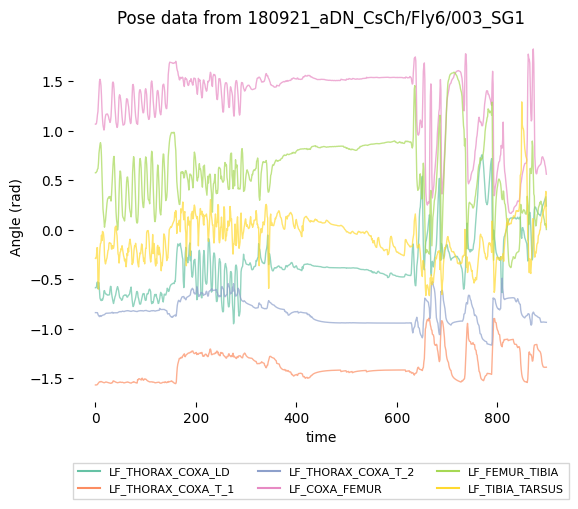

In [29]:
# See POSTURAL TIME SERIES:
stl.use('default')
see_postural_series(train_dataset.angl_exp_list.copy(), fly_tags, exp=21, joint=0, limb=0, H_angle=True)

In [29]:
# See all joint angles with statistical error data
see_post_series_stat(train_dataset.angl_exp_list.copy()) # best to keep rest frames so that discontinuities aren't considered

ValueError: Length of names must match number of levels in MultiIndex.

shapes: (120, 899) (899,)


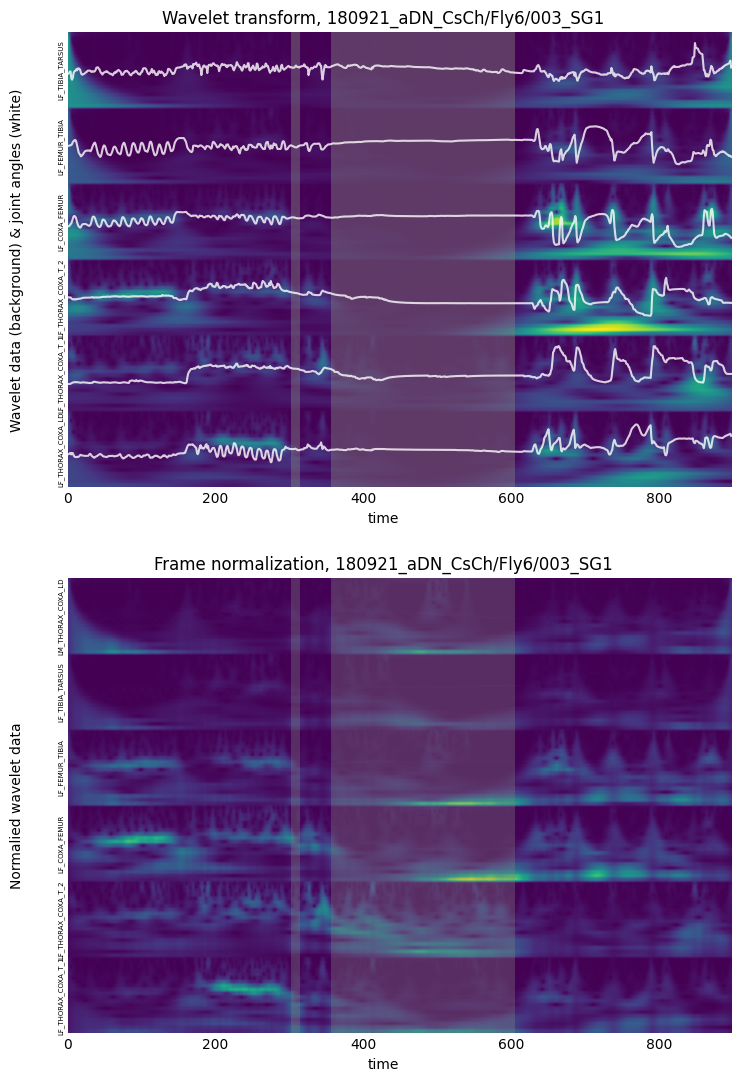

In [30]:
# TIME-FREQUENCY ANALYSIS: single plot from 1 joint and subject + all plots (pre and post NORMALIZATION step)
# WARNING: plot is different when called the 2nd time for the same joint angles (don't know why yet)
plt_wav(train_dataset.angl_exp_list.copy(), train_dataset.test_rest_mask, fly_tags, exp=21, j_ang=0, num_ang=6, 
        fps=100, chan=20, fmin=1, fmax=50, y_size=13, show_rest=True, show_pose=True, H_angles=True)

log10(variance threshold): -4.290214042818132
variance threshold: 5.1260868161146515e-05


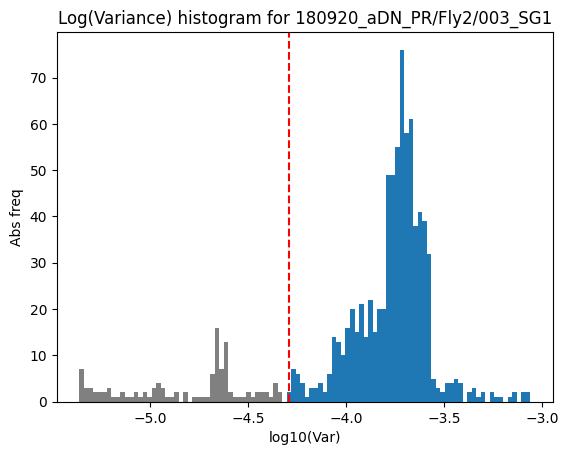

In [31]:
# Activity distribution and OTSU'S METHOD for clustering REST FRAMES:
is_bimodal(train_dataset.frame_var_list, fly_tags, exp=2, nbins=100) #correct map limits

## Dimensionality Reduction

$Z_1$      $Z_2$  Frame activity            Subject  Genotype  \
0     -35.509880 -89.517296       -0.189706    aDN_PR/Fly2/001    aDN_PR   
1     -35.375885 -89.610573       -0.210943    aDN_PR/Fly2/001    aDN_PR   
2     -35.224567 -89.725403       -0.230831    aDN_PR/Fly2/001    aDN_PR   
3     -35.089035 -89.836655       -0.253263    aDN_PR/Fly2/001    aDN_PR   
4     -34.944263 -89.950989       -0.276387    aDN_PR/Fly2/001    aDN_PR   
5     -34.738129 -90.096275       -0.295484    aDN_PR/Fly2/001    aDN_PR   
6     -34.477470 -90.265839       -0.312821    aDN_PR/Fly2/001    aDN_PR   
7     -34.131226 -90.469101       -0.326817    aDN_PR/Fly2/001    aDN_PR   
8     -33.675171 -90.726341       -0.339416    aDN_PR/Fly2/001    aDN_PR   
9     -33.142639 -91.032562       -0.351540    aDN_PR/Fly2/001    aDN_PR   
10    -32.606152 -91.349052       -0.363435    aDN_PR/Fly2/001    aDN_PR   
11    -32.100430 -91.648956       -0.373812    aDN_PR/Fly2/001    aDN_PR   
12    -31.594673 -91.941948       -0.379557    aDN_PR/Fly2/001    aDN_PR   
13    -31.155050 -92.188889       -0.383880    aDN_PR/Fly2/001    aDN_PR   
14    -30.794353 -92.394051       -0.384696    aDN_PR/Fly2/001    aDN_PR   
15    -30.484482 -92.559914       -0.385826    aDN_PR/Fly2/001    aDN_PR   
16    -30.218161 -92.697815       -0.393647    aDN_PR/Fly2/001    aDN_PR   
17    -29.999422 -92.804039       -0.408361    aDN_PR/Fly2/001    aDN_PR   
18    -29.811159 -92.889427       -0.422586    aDN_PR/Fly2/001    aDN_PR   
19    -29.632786 -92.972374       -0.434913    aDN_PR/Fly2/001    aDN_PR   
20    -29.445467 -93.048592       -0.441138    aDN_PR/Fly2/001    aDN_PR   
21    -29.256277 -93.105591       -0.444182    aDN_PR/Fly2/001    aDN_PR   
22    -29.035349 -93.138062       -0.448327    aDN_PR/Fly2/001    aDN_PR   
23    -28.793560 -93.153465       -0.458437    aDN_PR/Fly2/001    aDN_PR   
24    -28.551523 -93.154129       -0.469846    aDN_PR/Fly2/001    aDN_PR   
25    -28.342848 -93.137634       -0.477665    aDN_PR/Fly2/001    aDN_PR   
26    -28.177383 -93.148941       -0.480209    aDN_PR/Fly2/001    aDN_PR   
27    -28.061735 -93.192879       -0.483456    aDN_PR/Fly2/001    aDN_PR   
28    -27.984545 -93.293976       -0.488768    aDN_PR/Fly2/001    aDN_PR   
29    -27.920082 -93.459915       -0.496420    aDN_PR/Fly2/001    aDN_PR   
...          ...        ...             ...                ...       ...   
22344  -2.892126 -17.193428       -0.313831  aDN_CsCh/Fly7/004  aDN_CsCh   
22345  -2.916785 -17.354687       -0.325890  aDN_CsCh/Fly7/004  aDN_CsCh   
22346  -2.939270 -17.521099       -0.337189  aDN_CsCh/Fly7/004  aDN_CsCh   
22347  -2.969453 -17.685255       -0.347856  aDN_CsCh/Fly7/004  aDN_CsCh   
22348  -2.997284 -17.849579       -0.355871  aDN_CsCh/Fly7/004  aDN_CsCh   
22349  -3.025458 -18.015446       -0.360195  aDN_CsCh/Fly7/004  aDN_CsCh   
22350  -3.050340 -18.190102       -0.362066  aDN_CsCh/Fly7/004  aDN_CsCh   
22351  -3.081117 -18.371277       -0.360508  aDN_CsCh/Fly7/004  aDN_CsCh   
22352  -3.118163 -18.556932       -0.355959  aDN_CsCh/Fly7/004  aDN_CsCh   
22353 -33.016861 -82.065941       -0.350051  aDN_CsCh/Fly7/004  aDN_CsCh   
22354 -33.087116 -82.187073       -0.345338  aDN_CsCh/Fly7/004  aDN_CsCh   
22355 -33.166805 -82.285263       -0.340400  aDN_CsCh/Fly7/004  aDN_CsCh   
22356 -33.242058 -82.378326       -0.336397  aDN_CsCh/Fly7/004  aDN_CsCh   
22357 -33.338581 -82.472176       -0.335674  aDN_CsCh/Fly7/004  aDN_CsCh   
22358 -33.457352 -82.586136       -0.340337  aDN_CsCh/Fly7/004  aDN_CsCh   
22359 -33.625572 -82.739517       -0.347669  aDN_CsCh/Fly7/004  aDN_CsCh   
22360 -33.839046 -82.947609       -0.355564  aDN_CsCh/Fly7/004  aDN_CsCh   
22361 -34.096729 -83.213310       -0.360829  aDN_CsCh/Fly7/004  aDN_CsCh   
22362 -34.394871 -83.524063       -0.364262  aDN_CsCh/Fly7/004  aDN_CsCh   
22363 -34.730473 -83.883408       -0.364599  aDN_CsCh/Fly7/004  aDN_CsCh   
22364 -35.115402 -84.323036       -0.363144  aDN_CsCh/Fly7/

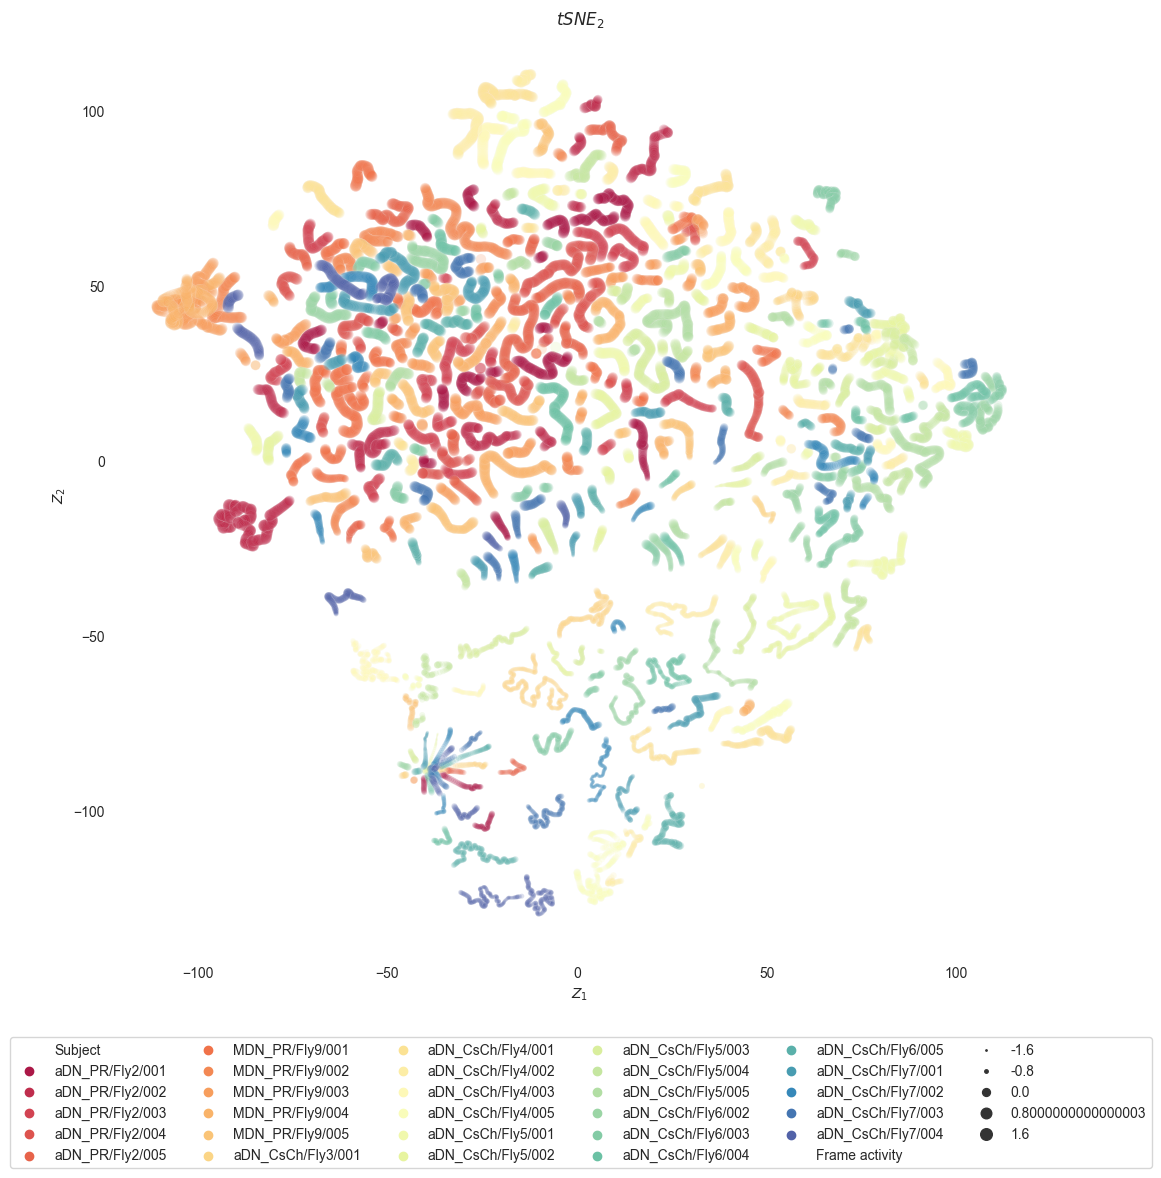

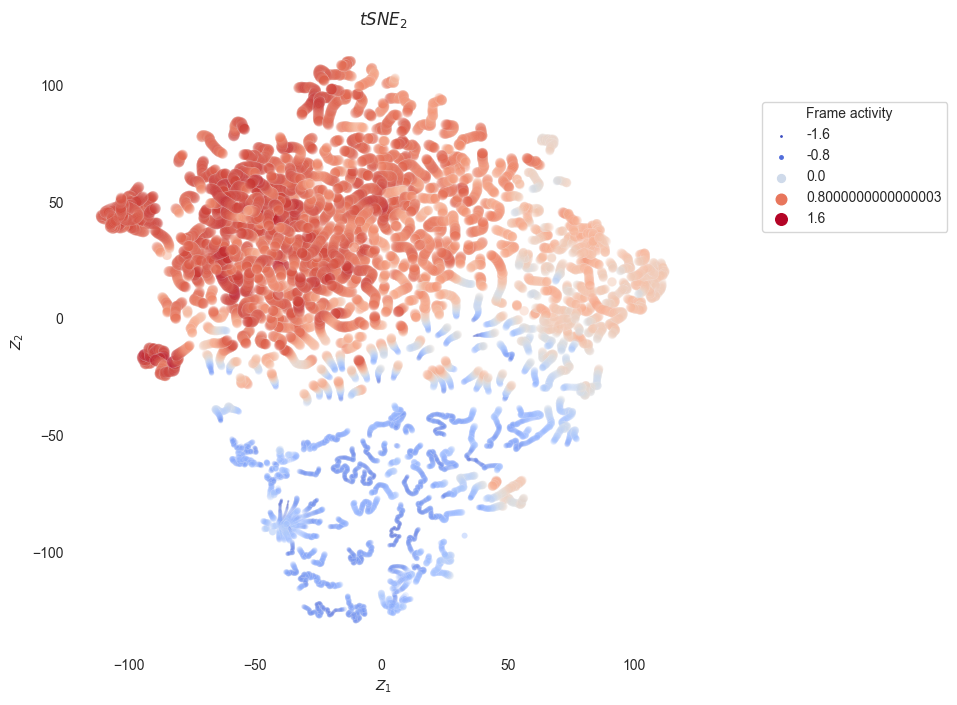

In [32]:
# Multiple scatter plots of the embedded 2D data
## reset parameters
plt.rcParams.update(plt.rcParamsDefault)
sns.set_style("white") # plt.style.use('dark_background')

data_frame_2d = see_2D_data(low_dim_train.copy(), np.log10(train_activity), fly_tags,
                            train_exp_index, low_dim.reducer_tag, results_dir, short_tags=True, tag_end=13)
data_frame_2d

## Segmentation

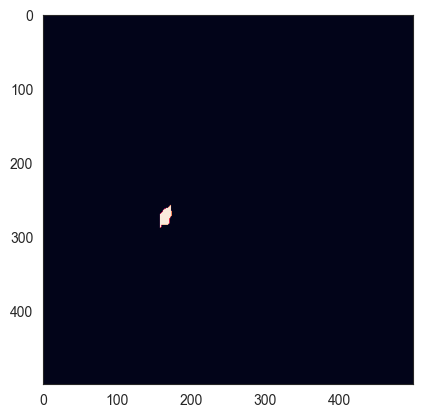

In [33]:
if segmentation.mode==0: #Watershed
    plt.imshow(cluster_labels==50)
elif segmentation.mode==1: #HDBSCAN
    f = plt.figure(figsize=(12,6))
    f.suptitle(pipeline, fontsize=18, y=.9, x=.5) # title eg.'$PCA_3$'+'$_0$'+'-$tSNE_2$'+'-$HDBSCAN$'
    ax1 = plt.subplot(1,1,1)
    sns.distplot(segmentation.hdbscan_scores[np.isfinite(segmentation.hdbscan_scores)], rug=False, ax=ax1)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
#     segmentation.single_linkage_tree.plot(axis=ax1)
#     ax2 = plt.subplot(2,1,2)
#     segmentation.cond_tree.plot(axis=ax2)

/Users/joaohenrique/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int32 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/Users/joaohenrique/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int32 to uint8 without scaling because max value 81 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Users/joaohenrique/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int32 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/Users/joaohenrique/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int32 to uint8 without scaling because max value 16 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/Users/joaohenrique/anaconda3/lib/python3.7/site-packa

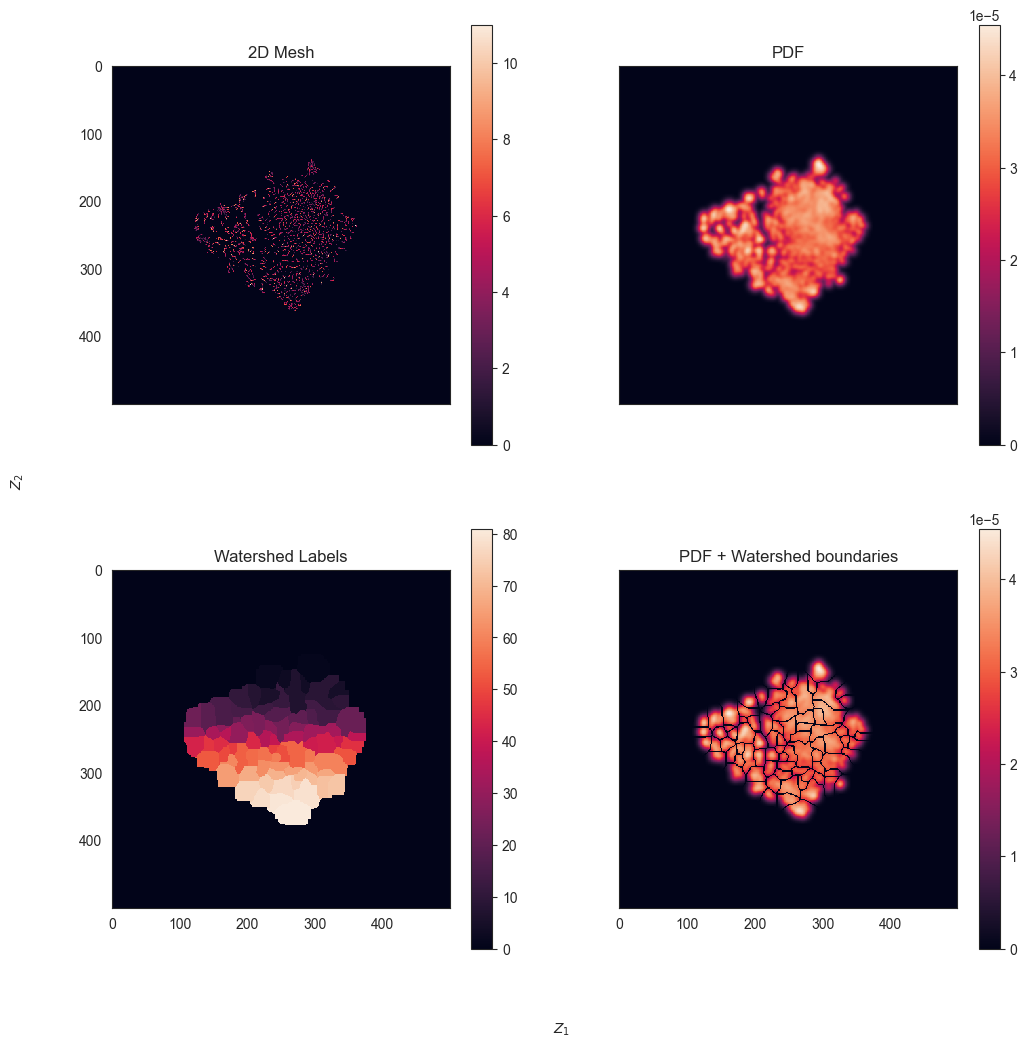

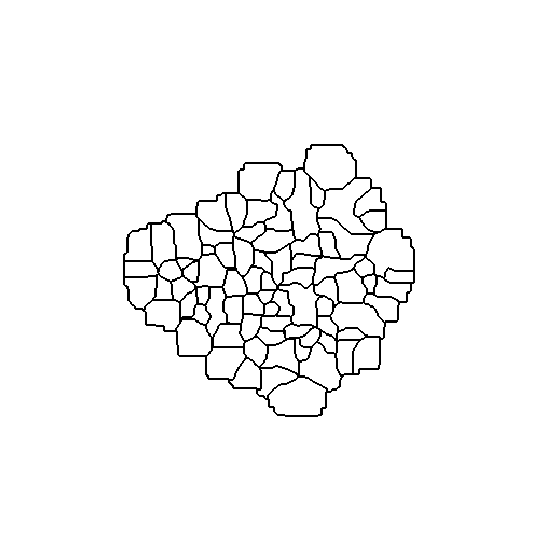

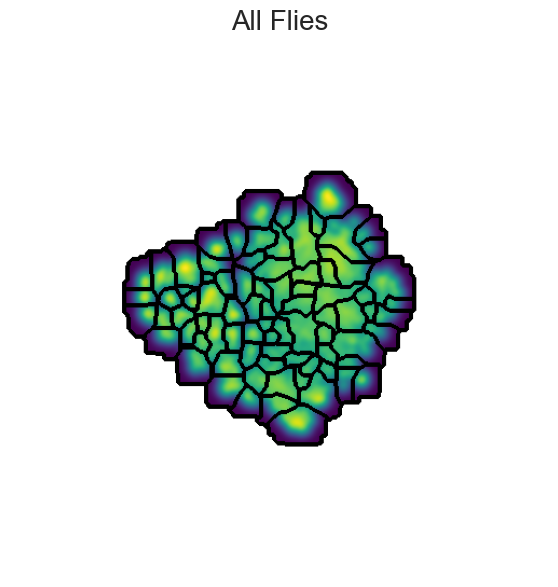

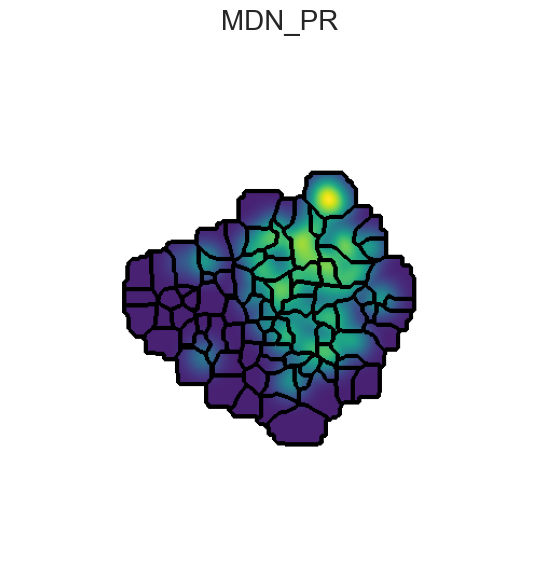

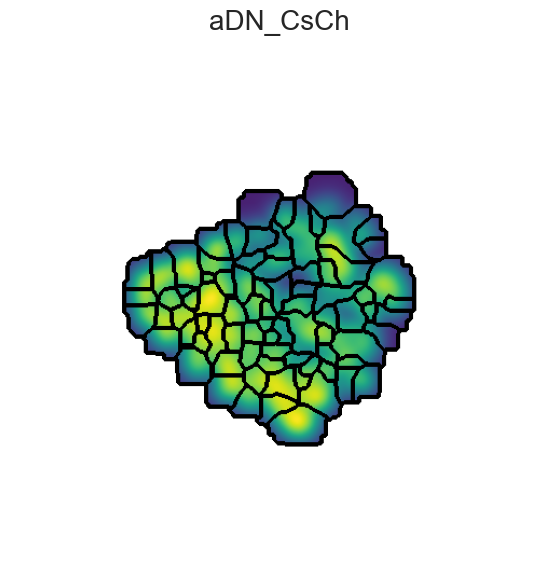

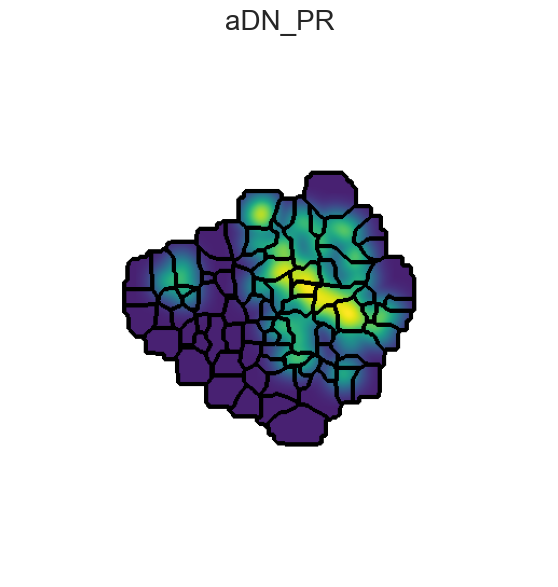

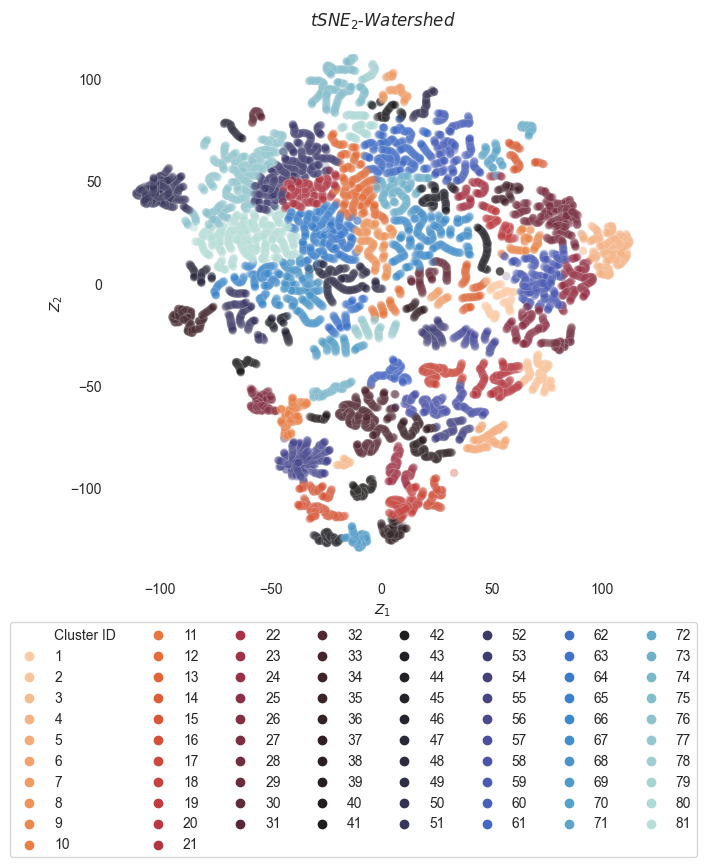

In [34]:
# See if mesh is ok. Pay attention to the MAGNITUDE parameter (Segmentation.py) when using Watershed 
# since t-SNE and PCA call for very different values.
pipeline = low_dim.reducer_tag + segmentation.seg_tag
data_frame_cluster = plt_segmentation(low_dim_train.copy(), cluster_labels, segmentation.prob_dens_f, segmentation.mesh,
                 segmentation.mask, mesh_bool, data_frame_2d, segmentation.mesh_mag,
                 segmentation.post_proba, segmentation.mode, segmentation.xmax, segmentation.ymax, 
                 segmentation.pix_to_point_idx, pipeline, results_dir)

## Cluster analysis

/Users/joaohenrique/Documents/EPFL/joao_pose/plot_results_util.py:599: RuntimeWarning: invalid value encountered in true_divide
  T = (M.T / M.sum(axis=1)).T
/Users/joaohenrique/Documents/EPFL/joao_pose/plot_results_util.py:667: RuntimeWarning: divide by zero encountered in log
  np.log(totals), outliers, np.log(outliers)]),


Mean dwell time is 43.44466019417476 frames
Cluster entropy is 4.165401751644712


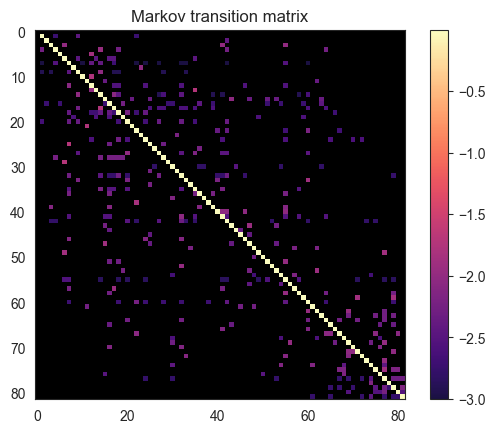

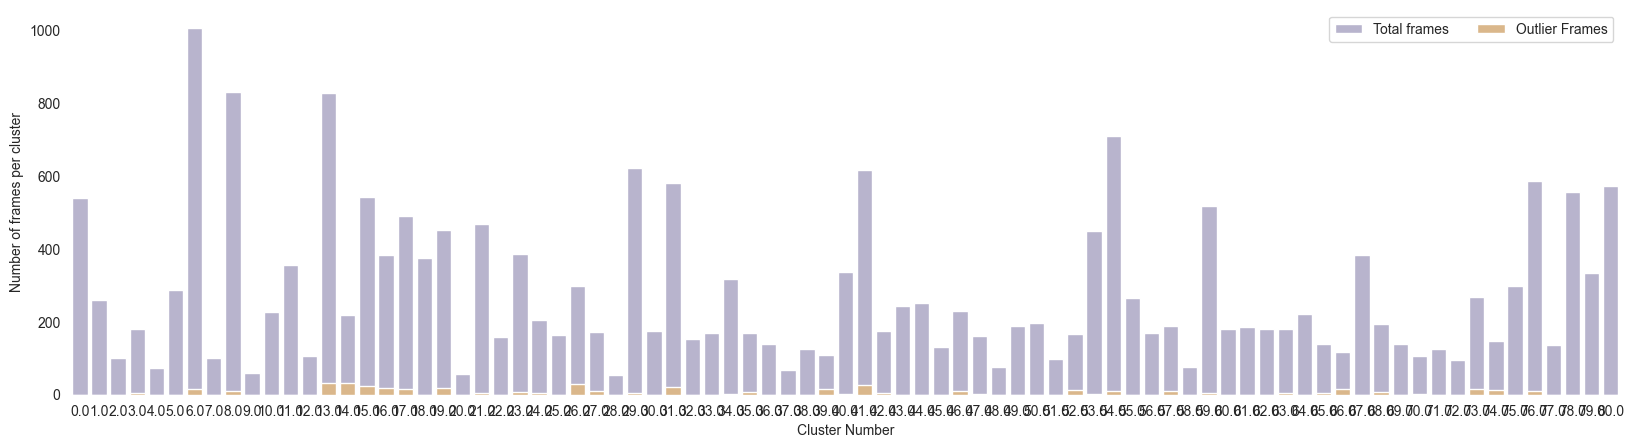

In [35]:
m = plot_Markov_matx(segmentation.mesh, segmentation.labels, segmentation.pix_to_point_idx,
                     segmentation.xmax, segmentation.ymax, mode=segmentation.mode)
frame_numbers, mean_dwell, cluster_entropy = cluster_frame_dist(results.cluster_dict)
plot_cluster_frame_dist(frame_numbers, dims=(20, 5))

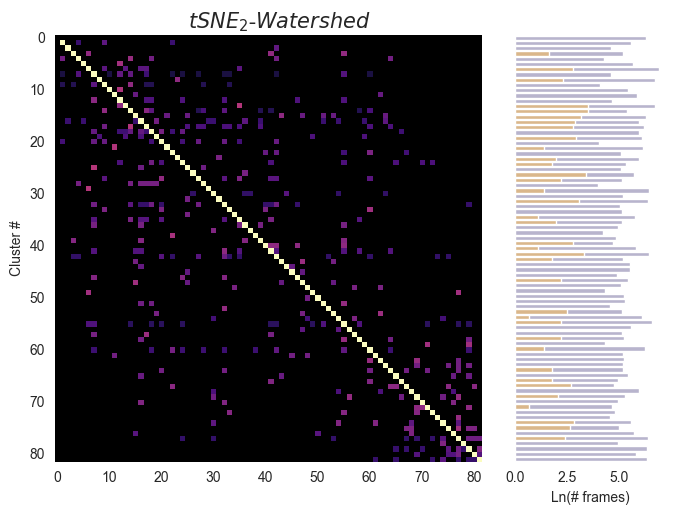

In [36]:
#Merge 2 previous plots
plot_markov_hist(m, frame_numbers, results_dir, titl=pipeline, dims=(7,5))  
#'$PCA_3$'+'$_0$'+'-$tSNE_2$'+'-$HDBSCAN$'

Fly centroid distances std dev: 29069.897211521584


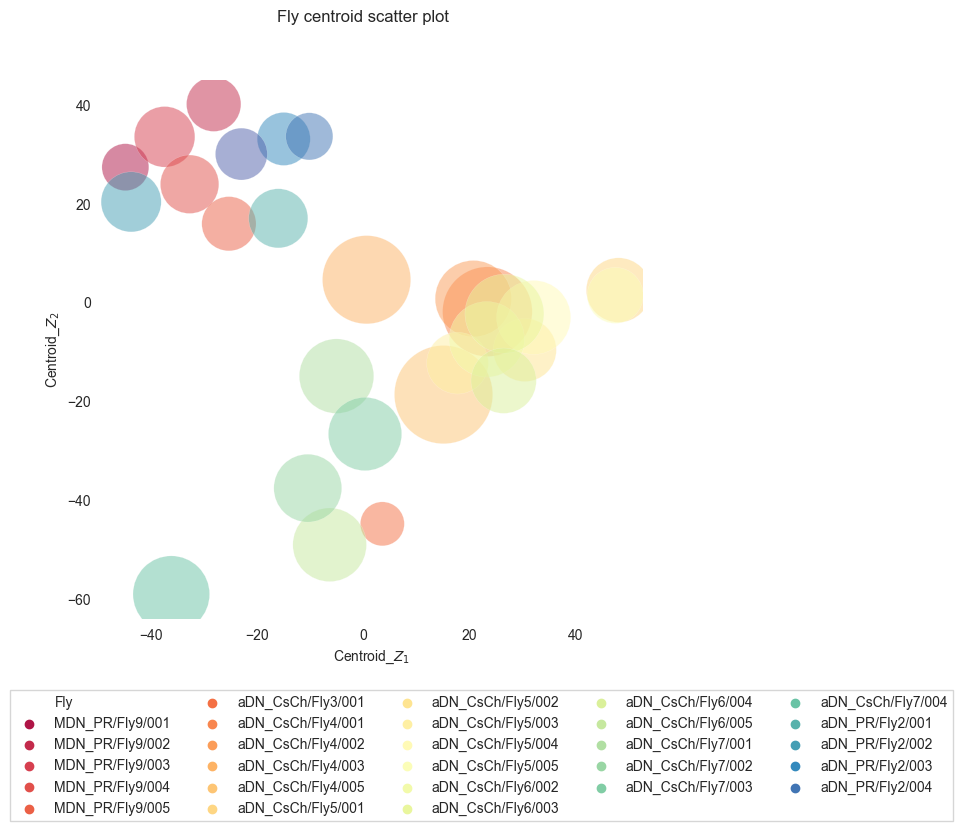

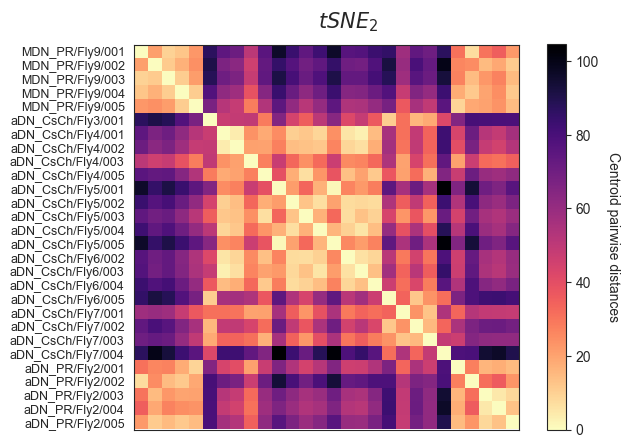

In [37]:
# Cluster Centroids for each fly
fly_centroids, fly_uncomp, centroid_dists, fly_arrays, embed_homog = fly_frame_dist(data_frame_cluster, 
                                                                                    low_dim.reducer_tag, results_dir)

## Store relevant metrics 

In [40]:
# Store: Entropy, Mean dwell time, pipeline total run time, prameters used (check modules) ...
run_t = train_dataset.dt+low_dim.dt+segmentation.dt
metrics_df = store_metrics(pipeline+'_$39a$', cluster_entropy, mean_dwell, embed_homog, run_t, 
                           fly_uncomp, centroid_dists, new_df=False)
metrics_df
# metrics_df = delete_df_line('/Users/joaohenrique/Documents/EPFL/joao_pose/results' + '/metrics_df.pickle', [8,33])

Pipeline   Entropy        Mdt   Homogeneity  \
0         $PCA_3$$_0$-$tSNE_2$-$GMM$_$39a$  4.393514  32.746556  24687.882401   
1         $PCA_3$$_0$-$tSNE_2$-$GMM$_$39a$  4.396651  33.146667  35194.502825   
2         $PCA_3$$_0$-$tSNE_2$-$GMM$_$39a$  4.387767  34.421538  25739.444212   
3         $PCA_3$$_0$-$tSNE_2$-$GMM$_$39a$  4.395485  33.443946  27898.210552   
4         $PCA_3$$_0$-$tSNE_2$-$GMM$_$39a$  4.385910  33.443946  27813.584100   
5         $PCA_3$$_0$-$tSNE_2$-$GMM$_$xyz$  4.369509  29.911765  28644.383609   
6         $PCA_3$$_0$-$tSNE_2$-$GMM$_$xyz$  4.366544  29.792277  25930.888576   
7         $PCA_3$$_0$-$tSNE_2$-$GMM$_$xyz$  4.379702  28.758355  29756.557156   
8         $PCA_3$$_0$-$tSNE_2$-$GMM$_$xyz$  4.362807  28.574713  28549.503541   
9         $PCA_3$$_0$-$tSNE_2$-$GMM$_$xyz$  4.361505  30.733516  30870.175722   
10  $PCA_3$$_0$-$tSNE_2$-$Watershed$_$xyz$  3.864605  39.740675  23019.474659   
11              $tSNE_2$-$Watershed$_$39a$  4.165402  43.444660  29069.897212   

           Time                                         Fly_Uncomp  \
0   2938.354752  [36.42412166016742, 39.38207974800337, 47.7905...   
1   2094.032268  [34.45792884809195, 41.99919415924845, 48.5026...   
2   2074.736414  [34.41335950970552, 41.673762107347585, 48.128...   
3   2095.111226  [34.4725310073922, 42.029874354573195, 48.0522...   
4   2180.968538  [34.05734353414143, 41.5472982998135, 47.99474...   
5   2153.332550  [32.44734257976319, 37.387205146902964, 46.629...   
6   2030.153256  [32.86556234589507, 37.26730626390915, 45.7820...   
7   1999.499601  [33.46105491340031, 37.556180679750206, 46.064...   
8   2484.838715  [32.452633194055394, 37.32882283739228, 46.041...   
9   3108.441288  [32.98213634626575, 37.276866707917286, 46.919...   
10  2204.598873  [34.32463666643358, 40.76195898308813, 47.5095...   
11  2736.770616  [35.890648170640574, 44.73420045729585, 51.641...   

                                        Centroid_dist  
0   [25.591384113286733, 18.986837426804602, 19.47...  
1   [29.15197846901976, 27.184948593547535, 22.431...  
2   [28.742339671543608, 26.360889226568997, 22.41...  
3   [29.007062719940365, 27.52457831934038, 22.618...  
4   [29.73191814434119, 27.314542190728204, 22.626...  
5   [31.309775937601486, 23.32946682651034, 18.656...  
6   [30.708321690570713, 22.638821557018797, 18.64...  
7   [31.316420110259013, 23.346554865855772, 18.74...  
8   [30.98910769135364, 23.19551055237697, 18.8053...  
9   [31.407078527691603, 23.005259752805802, 18.28...  
10  [28.550177603767352, 28.52409780258733, 23.887...  
11  [20.98827520808206, 9.624979614254984, 12.5988...

In [39]:
# metrics_df = delete_df_line('/Users/joaohenrique/Documents/EPFL/joao_pose/results' + '/metrics_df.pickle', [11,15])

## Testing

In [22]:
# Compare metric distributions between angles and 3D pose.
# Uncompactness
m_df = metrics_df.copy()
# uncomp_a = np.concatenate(m_df.loc[m_df['Pipeline'] == pipeline+'_$39a$']['Fly_Uncomp'])
# uncomp_xyz = np.concatenate(metrics_df.loc[metrics_df['Pipeline'] == pipeline+'_$xyz$']['Fly_Uncomp'])
# ^weird KeyError: 0
uncomp_a = np.concatenate((m_df['Fly_Uncomp'].iloc[0], m_df['Fly_Uncomp'].iloc[1],
                            m_df['Fly_Uncomp'].iloc[2], m_df['Fly_Uncomp'].iloc[3],
                            m_df['Fly_Uncomp'].iloc[4]))
uncomp_xyz = np.concatenate((m_df['Fly_Uncomp'].iloc[5], m_df['Fly_Uncomp'].iloc[6],
                            m_df['Fly_Uncomp'].iloc[7], m_df['Fly_Uncomp'].iloc[8],
                            m_df['Fly_Uncomp'].iloc[9]))
# Centroid_dist
# cd_a = np.concatenate(metrics_df.loc[m_df['Pipeline'] == pipeline+'_$39a$']['Centroid_dist'])
cd_a = np.concatenate((m_df['Centroid_dist'].iloc[0], m_df['Centroid_dist'].iloc[2],
                            m_df['Centroid_dist'].iloc[2], m_df['Centroid_dist'].iloc[4],
                            m_df['Centroid_dist'].iloc[4]))
cd_xyz = np.concatenate((m_df['Centroid_dist'].iloc[5], m_df['Centroid_dist'].iloc[6],
                            m_df['Centroid_dist'].iloc[7], m_df['Centroid_dist'].iloc[8],
                            m_df['Centroid_dist'].iloc[9]))

# Dictionary tags:
pipeline = list()
metric = list()
metric.extend(['Uncompactness' for i in range(len(uncomp_a)+len(uncomp_xyz))])
metric.extend(['Centroid_pair_distances' for i in range(len(cd_a)+len(cd_xyz))])
pipeline.extend(['Angles' for i in range(len(uncomp_a))])
pipeline.extend(['XYZ' for i in range(len(uncomp_xyz))])
pipeline.extend(['Angles' for i in range(len(cd_a))])
pipeline.extend(['XYZ' for i in range(len(cd_xyz))])
frm_data = np.concatenate((uncomp_a, uncomp_xyz, cd_a, cd_xyz))

assert len(metric) == len(pipeline) == len(frm_data)
a_vs_3d_df = pd.DataFrame()
a_vs_3d_df['Metric']=pd.Series(metric)
a_vs_3d_df['Pipeline']=pd.Series(pipeline)
a_vs_3d_df['Value']=pd.Series(frm_data)
a_vs_3d_df

Metric Pipeline      Value
0               Uncompactness   Angles  36.424122
1               Uncompactness   Angles  39.382080
2               Uncompactness   Angles  47.790569
3               Uncompactness   Angles  47.321322
4               Uncompactness   Angles  45.816760
5               Uncompactness   Angles  42.019148
6               Uncompactness   Angles  62.090448
7               Uncompactness   Angles  69.765467
8               Uncompactness   Angles  77.292341
9               Uncompactness   Angles  77.030907
10              Uncompactness   Angles  53.690661
11              Uncompactness   Angles  56.272684
12              Uncompactness   Angles  51.316795
13              Uncompactness   Angles  63.967954
14              Uncompactness   Angles  43.151108
15              Uncompactness   Angles  56.022927
16              Uncompactness   Angles  63.740658
17              Uncompactness   Angles  52.868805
18              Uncompactness   Angles  50.821908
19              Uncompactness   Angles  57.248649
20              Uncompactness   Angles  54.997239
21              Uncompactness   Angles  51.160681
22              Uncompactness   Angles  51.323699
23              Uncompactness   Angles  45.393193
24              Uncompactness   Angles  48.891079
25              Uncompactness   Angles  39.414915
26              Uncompactness   Angles  34.453238
27              Uncompactness   Angles  36.247837
28              Uncompactness   Angles  34.457929
29              Uncompactness   Angles  41.999194
...                       ...      ...        ...
4030  Centroid_pair_distances      XYZ  37.785703
4031  Centroid_pair_distances      XYZ  35.349945
4032  Centroid_pair_distances      XYZ  11.640755
4033  Centroid_pair_distances      XYZ  30.101943
4034  Centroid_pair_distances      XYZ  46.923077
4035  Centroid_pair_distances      XYZ  56.850039
4036  Centroid_pair_distances      XYZ  51.957256
4037  Centroid_pair_distances      XYZ  49.551514
4038  Centroid_pair_distances      XYZ  47.137043
4039  Centroid_pair_distances      XYZ  22.088309
4040  Centroid_pair_distances      XYZ  39.631361
4041  Centroid_pair_distances      XYZ  46.118966
4042  Centroid_pair_distances      XYZ  45.010038
4043  Centroid_pair_distances      XYZ  42.300861
4044  Centroid_pair_distances      XYZ  40.026047
4045  Centroid_pair_distances      XYZ  52.678609
4046  Centroid_pair_distances      XYZ  48.322169
4047  Centroid_pair_distances      XYZ  58.116813
4048  Centroid_pair_distances      XYZ  55.126994
4049  Centroid_pair_distances      XYZ  53.353502
4050  Centroid_pair_distances      XYZ  24.480516
4051  Centroid_pair_distances      XYZ   5.504892
4052  Centroid_pair_distances      XYZ   2.670490
4053  Centroid_pair_distances      XYZ   0.908328
4054  Centroid_pair_distances      XYZ  26.392183
4055  Centroid_pair_distances      XYZ  24.609826
4056  Centroid_pair_distances      XYZ  25.313661
4057  Centroid_pair_distances      XYZ   2.999928
4058  Centroid_pair_distances      XYZ   4.993378
4059  Centroid_pair_distances      XYZ   2.453172

[4060 rows x 3 columns]

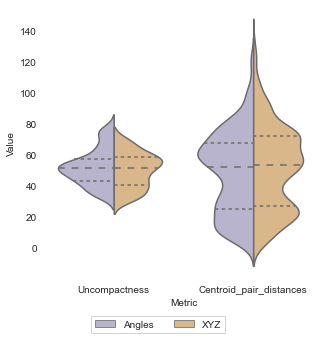

In [23]:
# Plot the differences
%matplotlib inline
f, ax = plt.subplots(figsize=(5, 5))
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x="Metric", y="Value", hue="Pipeline",
               split=True, inner="quart",
               palette={"Angles": sns.color_palette("PuOr", n_colors=12, desat=.9)[8],
                        "XYZ": sns.color_palette("PuOr", n_colors=12, desat=.7)[3]},
               data=a_vs_3d_df)
sns.despine(left=True, bottom=True)
# EXTRACT CURRENT HANDLES AND LABELS
h,l = ax.get_legend_handles_labels()
# COLOR LEGEND (FIRST 30 ITEMS)
col_lgd = plt.legend(h, l, loc='upper left', 
                     bbox_to_anchor=(0.15, -0.12), fancybox=False, shadow=False, ncol=5)

In [ ]:
freq_z1 = [3+20*0, 12+20*0, 19+20*0] # compare 2 by 2
freq_z2 = [3+20*20, 32+20*20, 39+20*20]
freqs = train_dataset.parameters_dict['wavelet_frequencies']
modes_z1 = np.hstack([train_data[:2000,i]*10**5 for i in freq_z1])
modes_z2 = np.hstack([train_data[:2000,i]*10**5 for i in freq_z2])
l = np.shape(train_data[:,0])[0]
names = list()
names.extend([f'f={freqs[freq_z1[0]]}Hz' for i in range(2000)])
# names.extend([f'f={freqs[freq_z1[1]]}Hz' for i in range(1000)])
# names.extend([f'f={freqs[freq_z1[2]]}Hz' for i in range(1000)])
mode_df = pd.DataFrame(np.transpose([modes_z1, modes_z2, names]), columns=['$A_i$','$A_j$','Frequency'])
mode_df

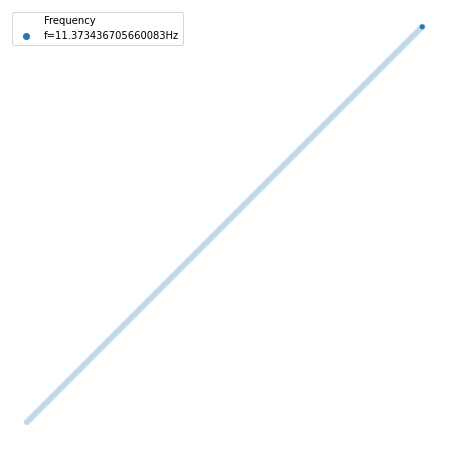

In [24]:
# Set up the figure
g, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
sns.despine(g, left=True, bottom=True)
ax.axis('off')
sns.scatterplot(x='$A_i$', y='$A_j$', hue='Frequency', data=mode_df, ax=ax, alpha=.5)

In [25]:
# print(f'Metric avg: {metrics_df.groupby("Pipeline")["Entropy"].mean()}; std dev: {metrics_df.groupby("Pipeline")["Entropy"].std()}')
uncomp = metrics_df.groupby('Pipeline')['Fly_Uncomp'].mean(); print(uncomp)
# metrics_df.groupby('Pipeline')['Mdt'].std()

DataError: No numeric types to aggregate

In [ ]:
cl = [1,1,3,3,6,6,2,2,1,7,7,5,5,4,4]
no = len(np.unique(cl))
cva = np.random.permutation(no)+1
print(cva)
ncl = [np.where(cva==i)[0][0]+1 for i in cl]
print(ncl)

In [ ]:
# Number of areas after Watershed vs kernel size, watershed near neighbours
# (Default) near neighbours = 5 / kernel size = 2,3,4,5,...,15
# a1 = [351, 244, 162, 117, 78, 64]
k_sizes = np.arange(2,15)
min_d = [2,5,10]
areas = np.zeros(shape=(len(min_d),len(k_sizes)))
for i in range(len(min_d)):
    for j in range(len(k_sizes)):
        segmentation = Segmentation(low_dim_train.copy(), mode=0, mesh_mag=4000, xmax=600, ymax=600, 
                                    k_size=k_sizes[j], w_mind=min_d[i])
        areas[i,j] = np.ndarray.max(segmentation.labels)
        
# Plot Distibution
labels = ['min_dist = 2', 'min_dist = 5', 'min_dist = 10']
areas_df = pd.DataFrame(np.transpose(areas), columns=labels)
g = sns.lineplot(data=areas_df, palette="Set2", linewidth=1.5, dashes=False, alpha=.7, markers=True)
sns.despine(left=True, right=True, top=True, bottom=True)
g.set_xticks(range(len(k_sizes))) # <--- set the ticks first
g.set_xticklabels(k_sizes)
plt.title('Number of areas')
plt.xlabel('Gaussian convolution kernel size')

In [ ]:
# Evaluate BIC score of GMM segmentation by varying k, the number of components, and finding the knee of the curve.
n_components = np.arange(1,150)
models = [Segmentation(low_dim_train.copy(), mode=2, mesh_mag=1, xmax=500, ymax=500, gmm_comps=n) for n in n_components]

# Plot Distibution
labels = ['BIC', 'AIC']
crit_df = pd.DataFrame(np.transpose([[m.bic for m in models], [m.aic for m in models]]),
                       columns=labels)
g = sns.lineplot(data=crit_df, palette="Set2", linewidth=1.5, dashes=False, alpha=.7, markers=False)
sns.despine(left=True, right=True, top=True, bottom=True)
# g.set_xticks(range(len(np.arange(60,80)))) # <--- set the ticks first
# g.set_xticklabels(np.arange(60,80))
plt.title('Criteria for GMM model selection')
plt.xlabel('Number of mixture components')

In [ ]:
# lets say I want to see frames 10 to 20 from a Fly experiment #3
# train_frame_index[ar_frm][train_exp_index[ar_frm]==exp_idx]
min_f = np.where(train_exp_index == 3)[0][10]
max_f = np.where(train_exp_index == 3)[0][20]
np.shape(train_data[min_f:max_f])

In [ ]:
# import cmasher as cmr
# cmap = cmr.redshift
# sns.palplot(sns.diverging_palette(250, 20, center='dark', l=40, s=70, n=10, as_cmap=False))
# sns.palplot(sns.cubehelix_palette(n_colors=80, start=2, rot=1, gamma=.9,
#                                   hue=.9, light=0.95, dark=0.01, reverse=True, as_cmap=False))
sns.palplot(sns.color_palette('magma', n_colors=10, desat=.7))